<a href="https://colab.research.google.com/github/threegenie/sentiment_project/blob/main/kakaopage_playstore_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 카카오페이지 플레이스토어 리뷰 분석
- 데이터 출처 : 직접 크롤링(2021.06.08, https://drive.google.com/file/d/1JBZmRP-Dcc69sQFgPqELTVUYrYCRIBRN/view?usp=sharing)
- 데이터 선정 이유 : 플레이스토어에 출시된 대표 어플리케이션들은 보통 긍정 리뷰가 많은 데에 반해, 이 리뷰에서는 긍정 리뷰와 부정 리뷰의 분포가 비교적 잘 드러나 있었기 때문에 선정하였다.

In [1]:
! pip install konlpy

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

# https://pinkwink.kr/1255 / https://teddylee777.github.io/colab/colab-korean 한글 문제 대응 참고

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
# 오류(SettingWithCopyError 발생)
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# 경고(SettingWithCopyWarning 발생, 기본 값입니다)
pd.set_option('mode.chained_assignment', 'warn') # SettingWithCopyWarning

# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [7]:
df = pd.read_csv('kakaopage_data.csv')

In [8]:
df = df.drop(['name','date','helpful','developer_comment'],axis=1)

In [9]:
df.head()

,ratings,comment
0,3,이거 갑자기는 아닌것 같은데 원래 스크롤 형식이랑 새롭게 바뀐 형식중에서 선택해서 ...
1,3,epub 개선해주세요. epub이 글씨 크기나 여러가지를 사용자 편의로 설정할 수 ...
2,3,웹툰 로딩이 너무 심각해요 제 데이터나 와이파이문제인가 싶어 확인해봐도 카카오페이지...
3,2,핸드폰을 새로 사서 설치를 했는데 알림이 오지 않습니다ㅜㅜ 알림이 오지 않을 시 설...
4,5,소설에 소장권 말고 50캐시인 대여권이 추가 됫으면 좋겟음...책갈피도 추가됫으면 ...


In [10]:
df = df.fillna(0)

In [11]:
df.shape

(440, 2)

In [12]:
df = df.rename(columns={'comment':'reviews'})

#### 별이 3개인 어중간한 데이터 제거

In [13]:
three = df[df['ratings']==3].index
df = df.drop(three)
df.shape

(336, 2)

#### 훈련, 테스트셋 분리

In [14]:
train, val = train_test_split(df, test_size = 0.1, random_state = 11)
train.shape, val.shape

((302, 2), (34, 2))

#### 별점으로 라벨링 : 별점이 4을 넘으면 긍정 리뷰, 이하는 부정 리뷰로 분류

In [15]:
def star_evaluate(rating):
  if rating >=4:
    return 1
  else:
    return 0
  
train['label'] = train['ratings'].apply(star_evaluate)
val['label'] = val['ratings'].apply(star_evaluate)
train

,ratings,reviews,label
198,1,"오늘 3월 23일 ""사용 중지""라는 문구와 웹 업데이트 및 삭제 후 재 설치하여도,...",0
350,1,어제 밤까지 잘 쓰다가 오늘 오전부터 계속 로딩창 이후 광고창 뜨자마자 터치도 안먹...,0
379,1,몇몇 웹툰들(15세이상웹툰 등등)이 보관함에 보이지않고 알람만 옵니다.알람을 바로바...,0
354,1,로판 기다무 코너에서는 육아물 회빙환이 아니면 아예 작가님들 진입이 힘든가 봐요?문...,0
352,1,아니다운로드해도캐시가안들어옴장난함?1번도아니고2번이나,0
...,...,...,...
221,4,최근 유료로 600캐시를 써서 100캐시를 받는데 제가 새벽에 들어와서 이용권을 구...,1
353,5,"옛날 추억에 만화인 ""테일즈런너 이야기 마법사""가 너무보고싶어요ㅠㅠ 만화카페에도없고...",1
125,5,기다리고 있는 로판이 많아요... 휴재한 작가님들 빨리 돌아올 수 있게 해주세요 ㅠㅠㅠㅠ,1
108,1,캐시관련 이벤트 관련 미지급이 매우 많고 문의를 해도 동문서답이 많음 뽑기권은 제대...,0


In [16]:
train['label'].value_counts()

0    158
1    144
Name: label, dtype: int64

#### 데이터 정제 - 훈련, 테스트셋에 모두 적용 -> 정규표현식 사용하여 한글 제외 모두 제거

In [17]:
train['reviews'] = train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['reviews'].replace('', np.nan, inplace=True)
train.head()

,ratings,reviews,label
198,1,오늘 월 일 사용 중지라는 문구와 웹 업데이트 및 삭제 후 재 설치하여도 사용할 수...,0
350,1,어제 밤까지 잘 쓰다가 오늘 오전부터 계속 로딩창 이후 광고창 뜨자마자 터치도 안먹...,0
379,1,몇몇 웹툰들세이상웹툰 등등이 보관함에 보이지않고 알람만 옵니다알람을 바로바로 지우고...,0
354,1,로판 기다무 코너에서는 육아물 회빙환이 아니면 아예 작가님들 진입이 힘든가 봐요문장...,0
352,1,아니다운로드해도캐시가안들어옴장난함번도아니고번이나,0


In [18]:
val['reviews'] = val['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
val['reviews'].replace('', np.nan, inplace=True)
val.head()

,ratings,reviews,label
205,5,카카오페이지 오랫동안 너무 잘 이용하고있는데 어젠가 엊그제부터 갑자기 오류코드가 한...,1
253,1,진짜 휴대폰 밝기랑 카카페 만화 밝기 따로따로 하는 거 좀 고쳐줬으면 좋겠네요 어두...,0
363,5,아니 앱 자체는 정말 좋게 쓰고 있었거든요 근데 갑자기 카카페에 들어가질 수가 없네...,1
416,5,갤럭시울트라 사용중이에요 카카오페이지 외 여러 어플들 강제종료 되서 서비스센터 문의...,1
210,5,자료가 많아 정말 좋은데 앱사용은 자꾸 꺼리게되네요 소설볼때도 배경 색상조절이던지 ...,1


#### 토큰화 - Okt 사용

In [19]:
from konlpy.tag import Okt
okt = Okt()

In [20]:
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '로', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [21]:
train['tokenized'] = train['reviews'].apply(okt.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [22]:
val['tokenized'] = val['reviews'].apply(okt.morphs)
val['tokenized'] = val['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [23]:
train.head()

,ratings,reviews,label,tokenized
198,1,오늘 월 일 사용 중지라는 문구와 웹 업데이트 및 삭제 후 재 설치하여도 사용할 수...,0,"[오늘, 월, 일, 사용, 중지, 라는, 문구, 웹, 업데이트, 및, 삭제, 후, ..."
350,1,어제 밤까지 잘 쓰다가 오늘 오전부터 계속 로딩창 이후 광고창 뜨자마자 터치도 안먹...,0,"[어제, 밤, 까지, 잘, 쓰다가, 오늘, 오전, 부터, 계속, 로딩, 창, 이후,..."
379,1,몇몇 웹툰들세이상웹툰 등등이 보관함에 보이지않고 알람만 옵니다알람을 바로바로 지우고...,0,"[몇몇, 웹툰, 세이, 상, 웹툰, 등등, 보관, 함, 보이지, 않고, 알람, 만,..."
354,1,로판 기다무 코너에서는 육아물 회빙환이 아니면 아예 작가님들 진입이 힘든가 봐요문장...,0,"[로판, 기, 무, 코너, 에서는, 육아, 물, 회빙환, 아니면, 아예, 작가, 님..."
352,1,아니다운로드해도캐시가안들어옴장난함번도아니고번이나,0,"[아니, 다운로드, 해도, 캐시가안, 들어옴, 장난, 함번, 도아, 니, 고번, 이나]"


#### 단어 빈도에 따른 시각화 - Counter, Wordcloud 패키지 이용

In [24]:
negative_words = np.hstack(train[train.label == 0]['tokenized'].values)
positive_words = np.hstack(train[train.label == 1]['tokenized'].values)

In [25]:
nw = Counter(negative_words)
print(nw.most_common(20))

[('캐시', 108), ('안', 75), ('앱', 67), ('만', 50), ('계속', 47), ('하고', 41), ('다시', 41), ('로그인', 36), ('문제', 35), ('왜', 35), ('것', 34), ('으로', 34), ('너무', 30), ('오류', 30), ('못', 30), ('좀', 29), ('했는데', 29), ('설치', 28), ('어', 28), ('뷰', 28)]


In [26]:
nwc = nw.most_common(15)

In [27]:
! pip install wordcloud

{'캐시': 108, '안': 75, '앱': 67, '만': 50, '계속': 47, '하고': 41, '다시': 41, '로그인': 36, '문제': 35, '왜': 35, '것': 34, '으로': 34, '너무': 30, '오류': 30, '못': 30}


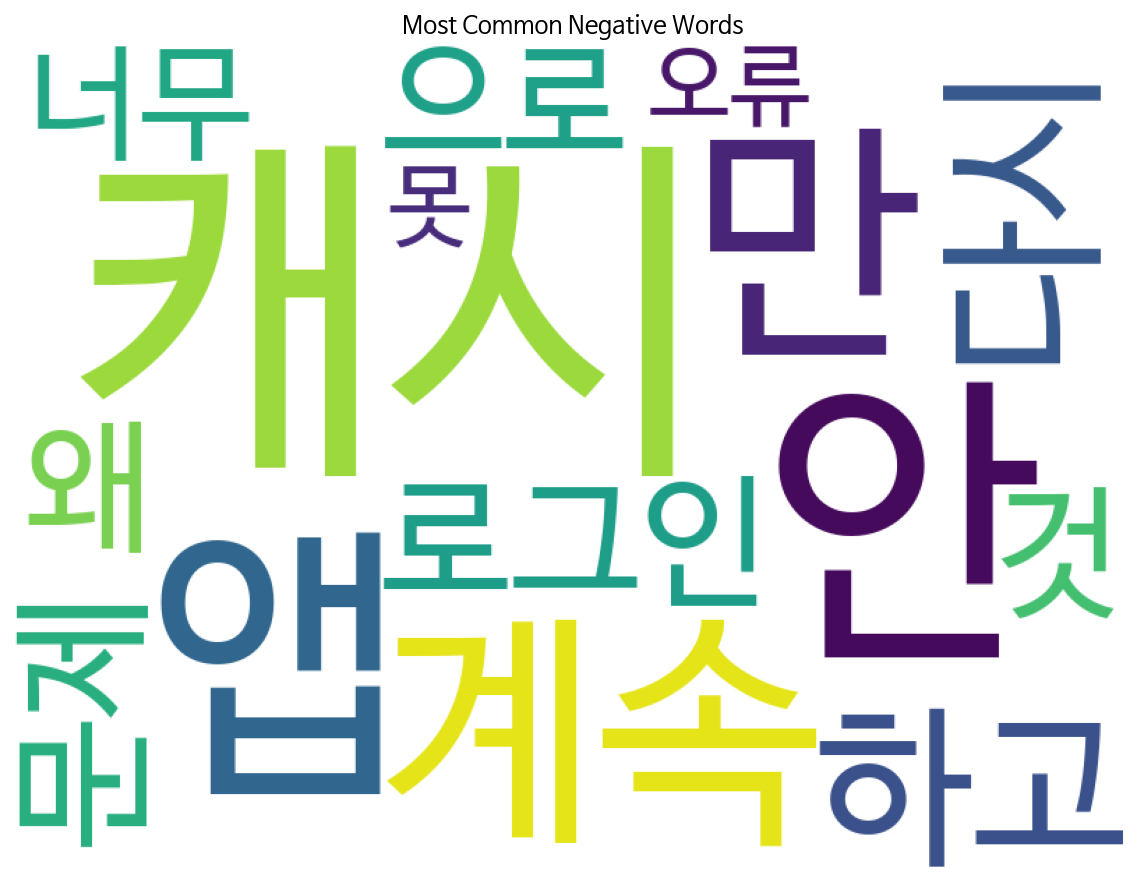

In [28]:
from wordcloud import WordCloud

#wordCloud생성
#한글꺠지는 문제 해결하기위해 font_path 지정
negative_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(nwc))
cloud = negative_word_cloud.generate_from_frequencies(dict(nwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Negative Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [29]:
pw = Counter(positive_words)
print(pw.most_common(20))

[('캐시', 126), ('앱', 58), ('하고', 57), ('너무', 56), ('으로', 52), ('수', 46), ('웹툰', 46), ('때', 43), ('잘', 43), ('안', 43), ('작품', 41), ('제', 38), ('것', 36), ('사용', 35), ('오류', 32), ('좀', 32), ('만', 30), ('계속', 27), ('무료', 26), ('할', 25)]


In [30]:
pwc = pw.most_common(15)

{'캐시': 126, '앱': 58, '하고': 57, '너무': 56, '으로': 52, '수': 46, '웹툰': 46, '때': 43, '잘': 43, '안': 43, '작품': 41, '제': 38, '것': 36, '사용': 35, '오류': 32}


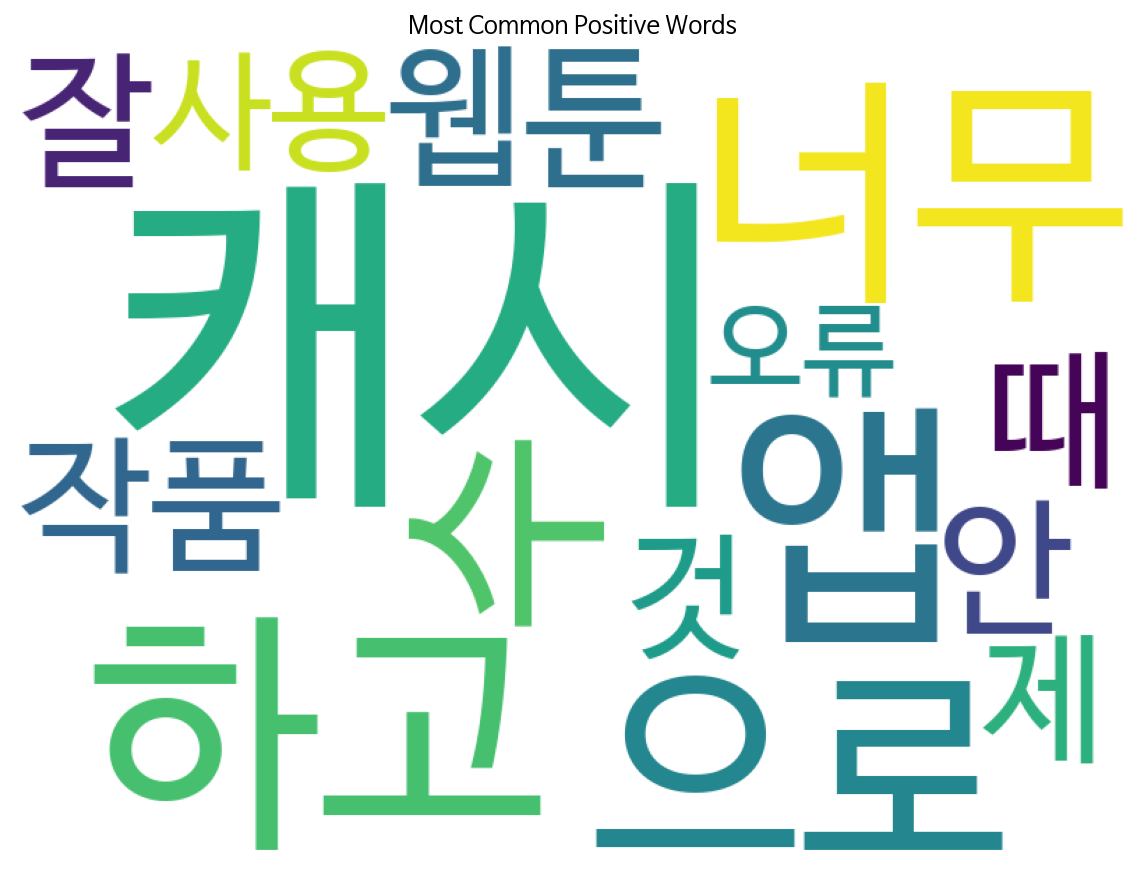

In [31]:
positive_word_cloud = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)
print(dict(pwc))
cloud = positive_word_cloud.generate_from_frequencies(dict(pwc))
plt.figure(figsize=(10, 8))
plt.title('Most Common Positive Words')
plt.axis('off')
plt.imshow(cloud)
plt.show()

#### 데이터에 정수 인코딩

In [32]:
X_train = train['tokenized']
y_train = train['label']
X_val= val['tokenized']
y_val = val['label']

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [34]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3735
등장 빈도가 1번 이하인 희귀 단어의 수: 2240
단어 집합에서 희귀 단어의 비율: 59.97322623828648
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 17.003188097768334


In [35]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1497


In [36]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)

리뷰의 최대 길이 : 160
리뷰의 평균 길이 : 43.62251655629139


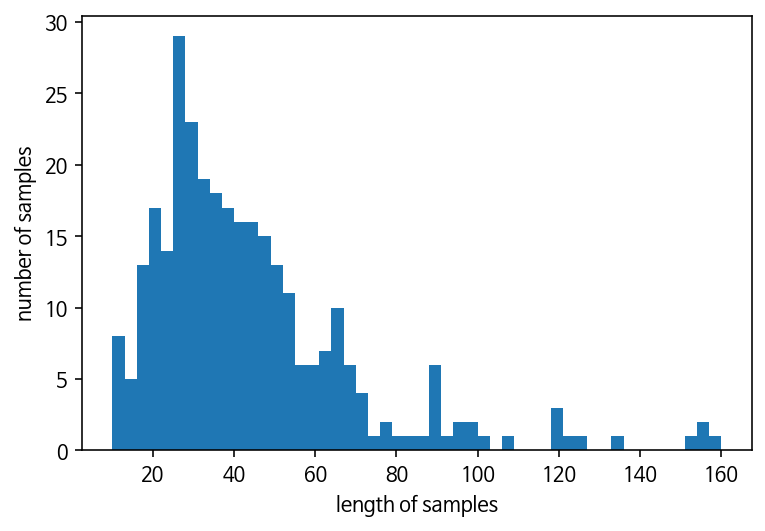

In [37]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
max_len = 80 #Padding 80으로
X_train = pad_sequences(X_train, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)


#### GRU 모델을 이용한 감성 분석

In [39]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [40]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='relu'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         149700    
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 238,149
Trainable params: 238,149
Non-trainable params: 0
_________________________________________________________________


In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [43]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
5/5 [==============================] - 4s 311ms/step - loss: 2.1524 - acc: 0.5436 - val_loss: 0.9016 - val_acc: 0.4426

Epoch 00001: val_acc improved from -inf to 0.44262, saving model to best_model.h5
Epoch 2/15
5/5 [==============================] - 1s 114ms/step - loss: 0.7279 - acc: 0.5394 - val_loss: 1.7284 - val_acc: 0.5574

Epoch 00002: val_acc improved from 0.44262 to 0.55738, saving model to best_model.h5
Epoch 3/15
5/5 [==============================] - 1s 121ms/step - loss: 0.6814 - acc: 0.6017 - val_loss: 0.7466 - val_acc: 0.4590

Epoch 00003: val_acc did not improve from 0.55738
Epoch 4/15
5/5 [==============================] - 1s 113ms/step - loss: 0.5249 - acc: 0.7012 - val_loss: 0.6952 - val_acc: 0.4918

Epoch 00004: val_acc did not improve from 0.55738
Epoch 5/15
5/5 [==============================] - 1s 119ms/step - loss: 0.3910 - acc: 0.9170 - val_loss: 0.7421 - val_acc: 0.5246

Epoch 00005: val_acc did not improve from 0.55738
Epoch 6/15
5/5 [============

#### model predict

In [44]:
print(val['reviews'])

205    카카오페이지 오랫동안 너무 잘 이용하고있는데 어젠가 엊그제부터 갑자기 오류코드가 한...
253    진짜 휴대폰 밝기랑 카카페 만화 밝기 따로따로 하는 거 좀 고쳐줬으면 좋겠네요 어두...
363    아니 앱 자체는 정말 좋게 쓰고 있었거든요 근데 갑자기 카카페에 들어가질 수가 없네...
416    갤럭시울트라 사용중이에요 카카오페이지 외 여러 어플들 강제종료 되서 서비스센터 문의...
210    자료가 많아 정말 좋은데 앱사용은 자꾸 꺼리게되네요 소설볼때도 배경 색상조절이던지 ...
319    제가 좋아하는 웹툰을 볼수있다는게 좋긴한데 캐시얻기가 너무힘들어요ㅠ 뽑기를해도 맨날...
301    앱이 응답되지 않는다고 튕기는거로 여기에 별점 테러 하고 계시는데 안드로이드 시스템...
311    웹툰 웹소설은 좋지만 이 문제 때문에 게시합니다 솔리테오 쿠르즈 세기 달성하면 캐시...
424    재미있는 소설과 웹툰이 많아 좋습니다 하지만 왜 안드로이드 테블릿에서는 가로로 세웠...
20     저기 전 카카오페이지를 정말 좋아하는 유저인데요 카카오페이지에서 읽고 싶은게 너무 ...
156         특정 읽기 형태에서는 배터리나 시계와 같은 상단바가 안나옵니다 나오게 바꿔주세요
76     저는 아직 미성년자라 보험이나 설문조사를 못해 앱을 깔거나 구독 팔로우를 해야만 캐...
389    다른건 다 좋은데 캐시가 잘 안들어 와요ㅜㅜ 캐시를 바로바로 넣어주시면 안되나요 한...
207    제발 이거 하나만 고쳐주세요ㅠ 열심히 레벨 해서 캐시 언제 들어오지 해서 들어가는데...
140    레전드인 사진형태 뷰어 ㅋㅋ 그럴려면 두쪽보기라도 가능하게 하던가 아이패드에서는 가...
234    강제로 효도폰 쓰는 기분 웹소 읽고 있는 데 문단마다 페이지를 나눠서 읽는데 집중을...
238    잘 보고있긴한데 점점 갈수록 짜지는거같아요 처음에는 걍 만화 편보면 캐시 주더니 이...
309    오늘 갑자기 앱 실행이 안돼네여어제는 멀쩡하

> GRU

In [45]:
def sentiment_predict_gru(sentence):
  sentence = okt.morphs(sentence) # 토큰화
  sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

실제 5점 리뷰

In [49]:
sentiment_predict_gru('자료가 많아 정말 좋은데 앱사용은 자꾸 꺼리게되네요.. 소설볼때도 배경 색상조절이던지 넘기는 방식같은게 선택을 할 수도없고 글꼴도 변경할 수도 없어서 다른 어플에 그 자료 있는지부터 찾아요..소설 글 읽어주는 시스템도 있으면 좋겠지만...앱 수정이 많이 되면 정말 잘 사용할 수 있을것 같네요ㅠㅠ')

89.68% 확률로 긍정 리뷰입니다.


실제 1점 리뷰

In [51]:
sentiment_predict_gru('UI가 모든 소설앱 중에서 최악입니다. 전체화면 아니고 아래위로 짤려 나오는 것두 문제고 폰트 크기 조절 안되는거도 문제고 페이지 넘김 효과 속도도 너무 느려요.. 페이지 넘김 애니 끌수있는 옵션도 없고... 다른 앱들 벤치마킹좀 하세요.. 보고싶은 소설 있어도 불편해서 볼 수가 없어요.. 로그인 방식도 카톡아이디 직접 입력되게 해주고요.. 투폰 쓰는데 불편합니다. 그리고 시리즈는 노트 팬으로 페이지 넘김 되는데 이건 왜 안되나요?? 아니면 마우스 휠로 페이지 넘길 수 있게 해주시던가요.. 제발 사용성 고려를 조금만이라도 했으면 하네요..')

63.16% 확률로 부정 리뷰입니다.
